In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader,Dataset, WeightedRandomSampler
import os
from PIL import Image
import pandas as pd
from torch.optim import lr_scheduler
from torch.utils.data import random_split
from collections import Counter
import numpy as np

In [3]:
gold_folder = "drive/MyDrive/md_hw3/Heart/golds"
train_image_folder="drive/MyDrive/md_hw3/Heart/images/tr"
val_image_folder="drive/MyDrive/md_hw3/Heart/images/val"
test_image_folder="drive/MyDrive/md_hw3/Heart/images/ts"

In [4]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        # Load only image files
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            if filename.endswith(".png"):
              img=np.array(Image.open(img_path).convert("L"),dtype=np.float32)
            else:
              img = np.array(Image.open(img_path).convert("RGB"))
            images.append(img)
    return images

# Load images from train, test, and validation folders
train_images = load_images_from_folder(train_image_folder)
test_images = load_images_from_folder(test_image_folder)
val_images = load_images_from_folder(val_image_folder)
gold_images=load_images_from_folder(gold_folder)

In [5]:
class CustomDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]


        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)




        return image, mask

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])




In [7]:
train_dataset = CustomDataset(train_images, gold_images[:len(train_images)],transform=transform)
val_dataset = CustomDataset(val_images, gold_images[len(train_images):len(train_images)+len(val_images)],transform=transform)
test_dataset = CustomDataset(test_images, gold_images[len(train_images)+len(val_images):],transform=transform)

In [8]:
train_dataset[0][1].shape

torch.Size([1, 512, 512])

In [9]:
np.max(np.array(val_dataset[34][1]))

1.0

In [11]:

class DoubleConv(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(DoubleConv,self).__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,3,1,1,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        #nn.Dropout(0.1),
        nn.Conv2d(out_channels,out_channels,3,1,1,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self,x):
      return self.conv(x)

class UNET(nn.Module):
    def __init__(
      self,in_channels=3,out_channels=1,features=[16,32,64,128],
      #self,in_channels=3,out_channels=1,features=[16,32,64],
      #self,in_channels=3,out_channels=1,features=[32,64,128,256],
      ):
      super(UNET,self).__init__()
      self.ups=nn.ModuleList()
      self.downs=nn.ModuleList()
      self.pool=nn.MaxPool2d(kernel_size=2,stride=2)

      for feature in features:
        self.downs.append(DoubleConv(in_channels,feature))
        in_channels=feature

      for feature in reversed(features):
        self.ups.append(nn.ConvTranspose2d(feature*2,feature,kernel_size=2,stride=2))
        self.ups.append(DoubleConv(feature*2,feature))

      self.bottleneck=DoubleConv(features[-1],features[-1]*2)
      self.final_conv=nn.Conv2d(features[0],out_channels,kernel_size=1)

    def forward(self,x):
      skip_connections=[]
      for down in self.downs:
        x=down(x)
        skip_connections.append(x)
        x=self.pool(x)

      x=self.bottleneck(x)
      skip_connections=skip_connections[::-1]

      for idx in range(0,len(self.ups),2):
        x=self.ups[idx](x)
        skip_connection=skip_connections[idx//2]

        if x.shape != skip_connection.shape:
          x=torchvision.transforms.functional.resize(x,size=skip_connection.shape[2:])
        concat_skip=torch.cat((skip_connection,x),dim=1)
        x=self.ups[idx+1](concat_skip)

      return self.final_conv(x)


In [12]:
model=UNET(in_channels=3,out_channels=1)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=4,shuffle=False)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET(in_channels=3,out_channels=1).to(device)


criterion = nn.BCEWithLogitsLoss()


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

In [15]:
for images, masks in train_loader:
 print(len(images))
 break

4


In [16]:
def metrics(preds,masks):
  tp=0
  fp=0
  fn=0
  fscore=0
  precision=0
  recall=0
  total_precision=0
  total_recall=0
  total_fscore=0
  precisions=[]
  recalls=[]
  fscores=[]

  for i in range(len(images)):
     tp = ((preds[i] == 1) & (masks[i]== 1)).sum().item()
     fp = ((preds[i]==1) & (masks[i]==0)).sum().item()
     fn = ((preds[i]==0) & (masks[i]==1)).sum().item()
     if tp==0:
       precision=0
       recall=0
       fscore=0
     else:
       precision = tp / (tp+fp)
       recall = tp/ (tp+fn)
       fscore = 2 * (precision * recall) / (precision + recall)
     precisions.append(precision)
     recalls.append(recall)
     fscores.append(fscore)
     total_recall+=recall
     total_precision+=precision
     total_fscore+=fscore
  return total_precision,total_recall,total_fscore,precisions,recalls,fscores






In [17]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    total_pixels=0
    total_correct_pixels=0
    pre=0
    rec=0
    fsc=0
    total_pre=0
    total_rec=0
    total_fsc=0


    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        # Convert predicted mask to binary (0 or 1)
        predicted_mask = torch.round(torch.sigmoid(outputs))

        #print(torch.max(masks))


        correct_pixels = (predicted_mask == masks).sum().item()
        total_correct_pixels += correct_pixels

        total_pixels += masks.numel()
        pre,rec,fsc,_,_,_ =metrics(predicted_mask,masks)
        total_pre+=pre
        total_rec+=rec
        total_fsc+=fsc
    scheduler.step()

    # Calculate average training loss
    train_loss /= len(train_dataset)
    # Calculate training accuracy
    train_accuracy = total_correct_pixels / total_pixels



    # Validation loop
    model.eval()
    val_loss = 0.0
    total_correct_pixels = 0
    total_predicted_pixels = 0
    total_true_pixels = 0
    total_pixels=0
    prev=0
    recv=0
    fscv=0
    total_prev=0
    total_recv=0
    total_fscv=0


    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            # Convert predicted mask to binary (0 or 1)
            predicted_mask = torch.round(torch.sigmoid(outputs))

            # Compute pixel-wise accuracy
            correct_pixels = (predicted_mask == masks).sum().item()
            total_correct_pixels += correct_pixels
            total_true_pixels += masks.sum().item()
            total_pixels += masks.numel()
            prev,recv,fscv,_,_,_ =metrics(predicted_mask,masks)
            total_prev+=prev
            total_recv+=recv
            total_fscv+=fscv

    # Calculate average validation loss
    val_loss /= len(val_dataset)
    # Calculate validation accuracy
    val_accuracy = total_correct_pixels / total_pixels


    # Print training and validation loss, accuracy, precision, recall, and F1-score
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Precision: {total_pre/len(train_dataset):.4f}, Train Recall: {total_rec/len(train_dataset):.4f}, Train F1-score: {total_fsc/len(train_dataset):.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {total_prev/len(val_dataset):.4f}, Validation Recall: {total_recv/len(val_dataset):.4f}, Validation F1-score: {total_fscv/len(val_dataset):.4f}")
model.eval()
total_correct_pixels = 0
total_predicted_pixels = 0
total_true_pixels = 0
total_pixels=0
pret=0
rect=0
fsct=0
total_pret=0
total_rect=0
total_fsct=0
predicted_masks = []
precisions=[]
recalls=[]
fscores=[]

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        # Convert predicted mask to binary (0 or 1)
        predicted_mask = torch.round(torch.sigmoid(outputs))
        predicted_masks.append(predicted_mask)

        # Compute pixel-wise accuracy
        correct_pixels = (predicted_mask == masks).sum().item()
        total_correct_pixels += correct_pixels

        total_true_pixels += masks.sum().item()
        total_pixels += masks.numel()
        pret,rect,fsct,p,r,f =metrics(predicted_mask,masks)
        total_pret+=pret
        total_rect+=rect
        total_fsct+=fsct
        precisions.append(p)
        recalls.append(r)
        fscores.append(f)

# Calculate test accuracy
test_accuracy = total_correct_pixels / total_pixels

# Print test accuracy, precision, recall, and F1-score
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {total_pret/len(test_dataset):.4f}, Test Recall: {total_rect/len(test_dataset):.4f}, Test F1-score: {total_fsct/len(test_dataset):.4f}")

Epoch [1/10], Train Loss: 0.5066, Train Accuracy: 0.9439
Train Precision: 0.3935, Train Recall: 0.5898, Train F1-score: 0.4072
Validation Loss: 0.5108, Validation Accuracy: 0.8940
Validation Precision: 0.1371, Validation Recall: 0.5769, Validation F1-score: 0.2083
Epoch [2/10], Train Loss: 0.3831, Train Accuracy: 0.9777
Train Precision: 0.6739, Train Recall: 0.7513, Train F1-score: 0.6639
Validation Loss: 0.3344, Validation Accuracy: 0.9723
Validation Precision: 0.0040, Validation Recall: 0.0151, Validation F1-score: 0.0063
Epoch [3/10], Train Loss: 0.3140, Train Accuracy: 0.9816
Train Precision: 0.7272, Train Recall: 0.7983, Train F1-score: 0.7293
Validation Loss: 0.3138, Validation Accuracy: 0.9726
Validation Precision: 0.0109, Validation Recall: 0.0012, Validation F1-score: 0.0022
Epoch [4/10], Train Loss: 0.2597, Train Accuracy: 0.9835
Train Precision: 0.7512, Train Recall: 0.8202, Train F1-score: 0.7534
Validation Loss: 0.2712, Validation Accuracy: 0.9726
Validation Precision: 0.1

In [18]:

p = [item for sublist in precisions for item in sublist if isinstance(item, float)]
p = np.array(p)
p=p.flatten()

r = [item for sublist in recalls for item in sublist if isinstance(item, float)]
r = np.array(r)
r=r.flatten()

f = [item for sublist in fscores for item in sublist if isinstance(item, float)]
f = np.array(f)
f=f.flatten()



def max_min_indices(array):
    # Get indices of maximum 2 elements
    max_indices = np.argpartition(array, -2)[-2:]

    # Get indices of minimum 2 elements
    min_indices = np.argpartition(array, 2)[:2]

    return max_indices, min_indices

def closest_to_average_indices(array):
    # Calculate the average of the array
    avg = np.mean(array)

    # Calculate the absolute differences between each element and the average
    differences = np.abs(array - avg)

    # Sort the differences and get the indices of the two smallest differences
    sorted_indices = np.argsort(differences)[:2]

    return sorted_indices

max,min=max_min_indices(f)
avg=closest_to_average_indices(f)
print(avg)
print(max)
print(min)


print("Second best Fscore: ",f[max[0]])
print("Best Fscore: ",f[max[1]])
print("Worst Fscore: ",f[min[0]])
print("Second worst Fscore: ",f[min[1]])
print("Acceptable fscore 1: ",f[avg[0]])
print("Acceptable fscore 2: ",f[avg[1]])




[ 0 45]
[71 68]
[56 33]
Second best Fscore:  0.9511357633386159
Best Fscore:  0.9555800800110359
Worst Fscore:  0.2885431400282885
Second worst Fscore:  0.3191629748326892
Acceptable fscore 1:  0.7718433051084024
Acceptable fscore 2:  0.7701680133384634


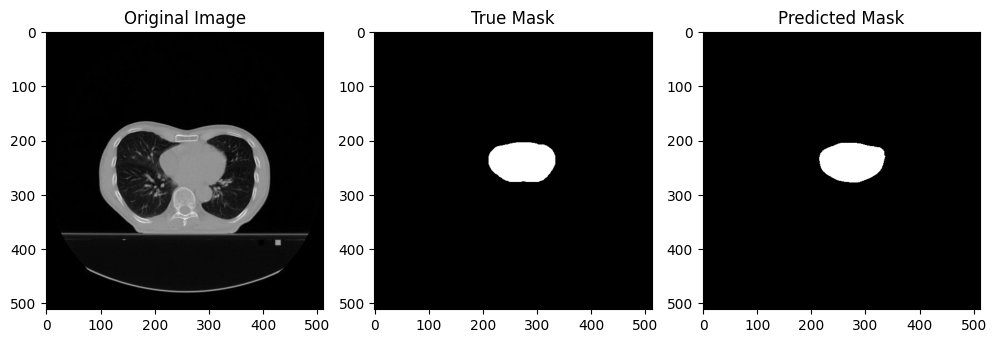

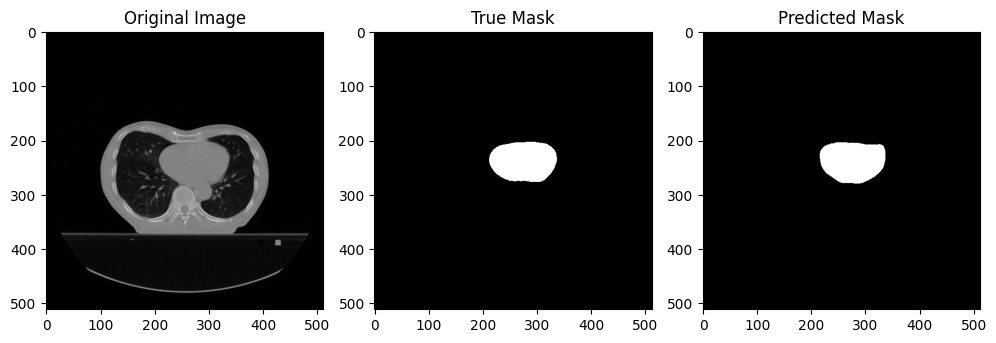

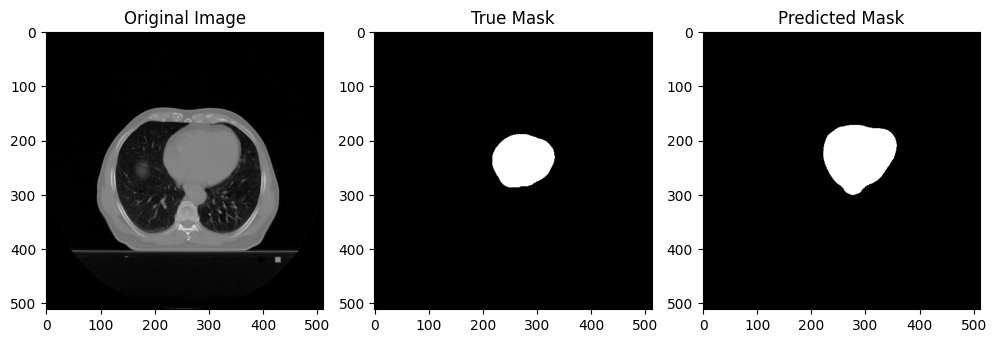

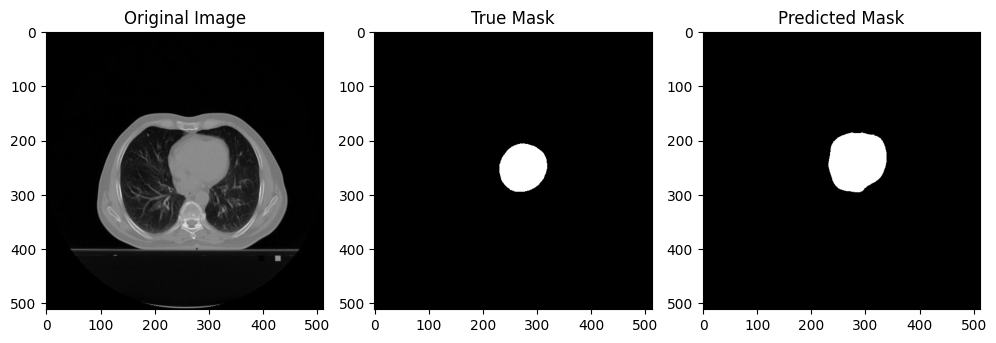

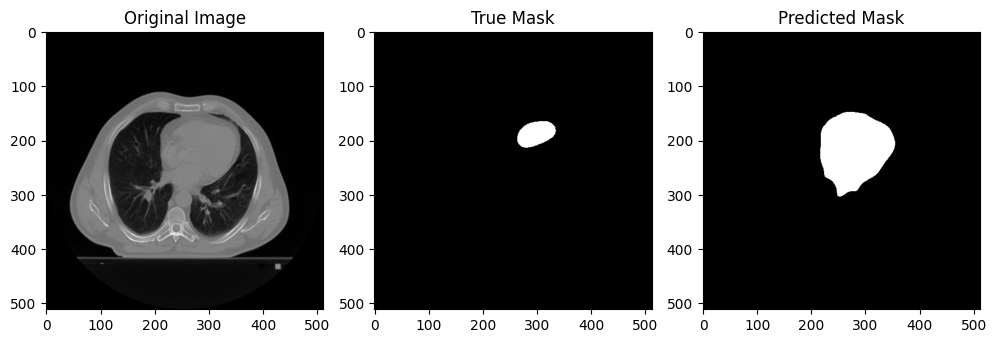

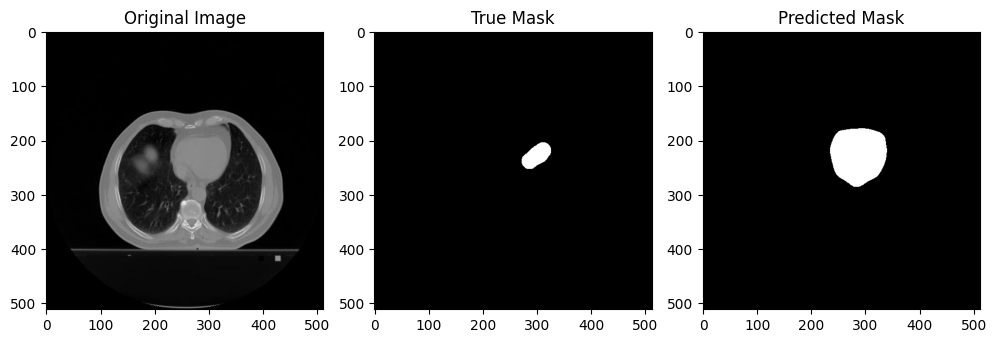

In [21]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def visualize_prediction(image, true_mask, predicted_mask):

    image = np.transpose(image, (1, 2, 0))
    true_mask = np.transpose(true_mask, (1, 2, 0))
    #predicted_mask=np.array(predicted_mask.cpu())
    predicted_mask=predicted_mask.cpu()
    predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

    #print(predicted_mask==1 & true_mask==1)


    cmap = ListedColormap(['black', 'white'])

    # Plot original image, true mask, and predicted mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.tight_layout()
    plt.show()


visualize_prediction(test_dataset[68][0], test_dataset[68][1], predicted_masks[17][0]) #best
visualize_prediction(test_dataset[71][0], test_dataset[71][1], predicted_masks[17][3]) #second best

visualize_prediction(test_dataset[0][0], test_dataset[0][1], predicted_masks[0][0]) #acceptable 1
visualize_prediction(test_dataset[45][0], test_dataset[45][1], predicted_masks[11][1]) #acceptable 2

visualize_prediction(test_dataset[56][0], test_dataset[56][1], predicted_masks[14][0]) #worst
visualize_prediction(test_dataset[33][0], test_dataset[33][1], predicted_masks[8][1]) #second worst

